In this notebook, we are going to implement a variation of REINFORCE algorithm. For a CartPole environment, a simple policy with a couple of parameters and logistic function will be enough.

## Defining a Policy

Logistic function (Sigmoid):
$$
f(x) = \frac{1}{1 + e^{-x}}
$$

Derivative of logistic function:

$$
\frac{df}{dx} = f(x)(1 - f(x))
$$

Lets take four parameters $W = w_0, w_1, w_2, w_3$ since the CartPole state $S$ consists of 4 variables. Now we can define a policy by multiplying weights with the state variables $W * S$ elementwise, then sum up the elements in the resulting vector and apply a sigmoid function. The output of sigmoid lies between 0 and 1, therefore we can treat it as a probability of selecting the first action (Remember, there are only two actions in CartPole). Actually, the element-wise multiplication of $W$ and $S$ with subsequent summation is just a **dot product**: $\sum_i W_i * S_i = W \cdot S$.

With this, we can already define the first methods.

```python
class LogisticAgent:
    def __init__(self, params, lr, gamma):
        # Initialize parameters, learning rate, and discount factor

        self.params = params
        self.lr = lr
        self.gamma = gamma

    def logistic(self, y):
        # definition of logistic function

        return 1 / (1 + np.exp(-y))

    def action_probs(self, x):
        # returns probabilities of two actions

        y = np.dot(x, self.params)
        prob0 = self.logistic(y)

        return np.array([prob0, 1 - prob0])

    def compute_action(self, x):
        # sample an action in proportion to probabilities

        probs = self.action_probs(x)
        action = np.random.choice([0, 1], p=probs)

        return action, probs[action]
```
## Running an episode
Next we need to define a method that will run one episode to collect the experiences:

```python
def run_episode(env, agent):

    observation = env.reset()
    totalreward = 0

    observations = []
    actions = []
    rewards = []
    probs = []

    done = False

    while not done:
        observations.append(observation)

        action, prob = agent.compute_action(observation)
        observation, reward, done, info = env.step(action)

        totalreward += reward
        rewards.append(reward)
        actions.append(action)
        probs.append(prob)

    return (
        totalreward,
        np.array(rewards),
        np.array(observations),
        np.array(actions),
        np.array(probs),
    )


```

Let's also define a ```train()``` method that will run several episodes in a loop.

```python
def train(
    env,
    params,
    lr,
    gamma,
    agent_cls,
    MAX_EPISODES=1000,
    plot_period=1,
    seed=None,
):

    # initialize environment and the agent
    if seed is not None:
        env.seed(seed)
    episode_rewards = []
    agent = agent_cls(params, lr, gamma)

    # train until MAX_EPISODES
    for i in range(MAX_EPISODES):
        stats = {}
        # run a single episode
        total_reward, rewards, observations, actions, probs = run_episode(env, agent)
        # keep track of episode rewards
        episode_rewards.append(total_reward)
        # update agent
        agent.update(rewards, observations, actions)

    return episode_rewards, agent

```

## Learning

Now, we have defined everything, apart from the most important piece, which is `agent.update()` method. Here, the learning will occur. This method will accept the list of rewards, observations and actions collect during one episode.

Let's remind ourselves what are the steps of REINFORCE algorithm:

<img src="https://i.stack.imgur.com/Acbup.png">

After we have collected the experiences we would also need to calculate returns $G_0, G_1, ..., G_{T-1}$. Let's define a method for this. We will simply loop over the rewards in reversed order and discount them with parameter $\gamma$.
```python
class LogisticAgent:
    def discount_rewards(self, rewards):
        # calculate temporally adjusted discounted rewards

        discounted_rewards = np.zeros(len(rewards))
        cumulative_rewards = 0
        for i in reversed(range(0, len(rewards))):
            cumulative_rewards = cumulative_rewards * self.gamma + rewards[i]
            discounted_rewards[i] = cumulative_rewards

        return discounted_rewards

```

The next step is to take the gradients of the logistics function $\nabla \operatorname{ln} \pi(A_t | S_t, \theta)$. For this we will define the following methods.

```python
class LogisticAgent:
    def grad_log_p(self, x):
        # calculate grad-log-probs

        y = np.dot(x, self.params)
        grad_log_p0 = x - x * self.logistic(y)
        grad_log_p1 = -x * self.logistic(y)

        return grad_log_p0, grad_log_p1

    def grad_log_p_dot_rewards(self, grad_log_p, actions, discounted_rewards):
        # dot grads with future rewards for each action in episode
        return np.dot(grad_log_p.T, discounted_rewards)

```

`grad_log_p()` will calculate $\nabla \operatorname{ln} \pi(A_t | S_t, \theta)$, while `grad_log_p_dot_rewards()` will calculate the sum of the rewards $\sum_{t=0}^{T-1} G_t * \nabla \operatorname{ln} \pi(A_t | S_t, \theta)$. Therefore the final `agent.update()` method will look like the following.

```python
    def update(self, rewards, obs, actions):
        # calculate gradients for each action over all observations
        grad_log_p = np.array(
            [self.grad_log_p(ob)[action] for ob, action in zip(obs, actions)]
        )

        assert grad_log_p.shape == (len(obs), 4)

        # calculate temporaly adjusted, discounted rewards
        discounted_rewards = self.discount_rewards(rewards)

        # gradients times rewards
        grad_surrogate_objective = self.grad_log_p_dot_rewards(grad_log_p, discounted_rewards)

        # gradient ascent on parameters
        self.params += self.lr * grad_surrogate_objective
```
Notice that we use the gradient of the log probability only for already executed action.

## Logistic Agent
Let's put everything together and run our agent in an environment.

In [5]:
%load_ext autoreload
%autoreload 2

In [ ]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.core import display


class LogisticAgent:
    def __init__(self, params, lr, gamma):
        # Initialize paramters, learning rate and discount factor

        self.params = params
        self.lr = lr
        self.gamma = gamma

    def logistic(self, y):
        # definition of logistic function

        return 1 / (1 + np.exp(-y))

    def action_probs(self, x):
        # returns probabilities of two actions

        y = np.dot(x, self.params)
        prob0 = self.logistic(y)

        return np.array([prob0, 1 - prob0])

    def compute_action(self, x):
        # sample an action in proportion to probabilities

        probs = self.action_probs(x)
        action = np.random.choice([0, 1], p=probs)

        return action, probs[action]

    def grad_log_p(self, x):
        # calculate grad-log-probs

        y = np.dot(x, self.params)
        grad_log_p0 = x - x * self.logistic(y)
        grad_log_p1 = -x * self.logistic(y)

        return grad_log_p0, grad_log_p1

    def grad_log_p_dot_rewards(self, grad_log_p, discounted_rewards):
        # dot grads with future rewards for each action in episode
        return np.dot(grad_log_p.T, discounted_rewards)

    def discount_rewards(self, rewards):
        # calculate temporally adjusted, discounted rewards

        discounted_rewards = np.zeros(len(rewards))
        cumulative_rewards = 0
        for i in reversed(range(0, len(rewards))):
            cumulative_rewards = cumulative_rewards * self.gamma + rewards[i]
            discounted_rewards[i] = cumulative_rewards

        return discounted_rewards

    def update(self, rewards, obs, actions):
        # calculate gradients for each action over all observations
        grad_log_p = np.array(
            [self.grad_log_p(ob)[action] for ob, action in zip(obs, actions)]
        )

        assert grad_log_p.shape == (len(obs), 4)

        # calculate temporaly adjusted, discounted rewards
        discounted_rewards = self.discount_rewards(rewards)

        # gradients times rewards
        grad_surrogate_objective = self.grad_log_p_dot_rewards(grad_log_p, discounted_rewards)

        # gradient ascent on parameters
        self.params += self.lr * grad_surrogate_objective


def run_episode(env, agent, render=False):

    observation = env.reset()
    totalreward = 0

    observations = []
    actions = []
    rewards = []
    probs = []

    done = False

    while not done:
        if render:
            env.render()

        observations.append(observation)

        action, prob = agent.compute_action(observation)
        observation, reward, done, info = env.step(action)

        totalreward += reward
        rewards.append(reward)
        actions.append(action)
        probs.append(prob)

    return (
        totalreward,
        np.array(rewards),
        np.array(observations),
        np.array(actions),
        np.array(probs),
    )


def train(
    env,
    params,
    lr,
    gamma,
    agent_cls,
    MAX_EPISODES=1000,
    plot_stats=None,
    plot_period=1,
    seed=None,
    evaluate=False,
    video_folder="",
):
    plot_stats = plot_stats or []
    if plot_stats:
        num_plots = len(plot_stats)
        fig, axs = plt.subplots(
            num_plots, 1, squeeze=False, figsize=(10, 5 * num_plots)
        )
        axs = axs.ravel()

    history = defaultdict(list)

    # initialize environment and the agent
    if seed is not None:
        env.seed(seed)
    episode_rewards = []
    agent = agent_cls(params, lr, gamma)

    # train until MAX_EPISODES
    for i in range(MAX_EPISODES):
        stats = {}
        # run a single episode
        total_reward, rewards, observations, actions, probs = run_episode(env, agent)
        # keep track of episode rewards
        episode_rewards.append(total_reward)
        # update agent
        agent.update(rewards, observations, actions)
        stats["score"] = total_reward

        for k, v in stats.items():
            history[k].append(v)

        if plot_stats:
            if (i + 1) % plot_period == 0:
                for ax, stat_name in zip(axs, plot_stats):
                    ax.clear()
                    # print(stat_name, len(history[stat_name]))

                    sns.lineplot(
                        x=np.arange(len(history[stat_name])),
                        y=history[stat_name],
                        ax=ax,
                    )

                    ax.set_title(stat_name)
                display.display(fig)
                display.clear_output(wait=True)

        else:
            print(
                f"episode {i}/{MAX_EPISODES} | {stats}",
            )

    return episode_rewards, agent

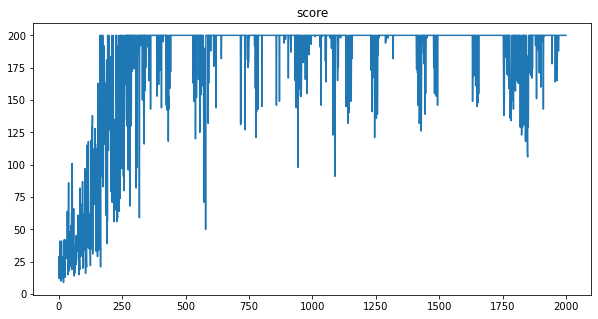

In [8]:
import gym

GLOBAL_SEED = 0
np.random.seed(GLOBAL_SEED)
env = gym.make("CartPole-v0")

episode_rewards, policy = train(
    env,
    params=np.random.rand(4),
    lr=0.002,
    gamma=0.99,
    agent_cls=LogisticAgent,
    MAX_EPISODES=2000,
    seed=GLOBAL_SEED,
    plot_stats=['score'],
    plot_period=100,
)